In [1]:
# Install required libraries
!pip install torch torchvision lime matplotlib scikit-learn scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=38d513259af0d0bd8efdf39a09018cfd407cfcb4dd9bd38e999a363bd53c5e56
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
# Import libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')


# Check for GPU availability
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [3]:
# Define dataset path (update path if necessary)
dataset_path = "/content/drive/MyDrive/processed_dataset"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize for MobileNetV2
    transforms.RandomRotation(30),   # Data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=transform)

# Check class-to-index mapping
print("Class Mapping:", dataset.class_to_idx)



Class Mapping: {'fall': 0, 'non_fall': 1}


In [4]:
# Split dataset into training and validation subsets
train_size = int(0.75 * len(dataset))  # 75% training
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


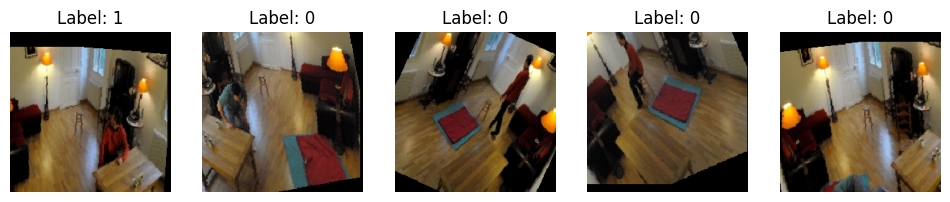

In [5]:
# Function to visualize samples
def visualize_samples(loader, num_samples=5):
    plt.figure(figsize=(12, 6))
    data_iter = iter(loader)
    images, labels = next(data_iter)
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Visualize training samples
visualize_samples(train_loader)


In [6]:
# Load Pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for binary classification
model.classifier[1] = nn.Sequential(
    nn.Linear(model.last_channel, 1),  # Binary classification
    nn.Sigmoid()
)
model = model.to(device)

# Print the updated model architecture (optional)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 152MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [7]:
# Updated Training Function
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        y_true, y_pred = [], []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(imgs).squeeze()  # Adjusted for MobileNetV2
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = (outputs > 0.5).int()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_accuracy = accuracy_score(y_true, y_pred)
        history["loss"].append(train_loss / len(train_loader))
        history["accuracy"].append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss, val_y_true, val_y_pred = 0, [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device).float()
                outputs = model(imgs).squeeze()  # Adjusted for MobileNetV2
                val_loss += criterion(outputs, labels).item()
                preds = (outputs > 0.5).int()
                val_y_true.extend(labels.cpu().numpy())
                val_y_pred.extend(preds.cpu().numpy())

        val_accuracy = accuracy_score(val_y_true, val_y_pred)
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_accuracy"].append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    return history


In [8]:
# Train the model
history = train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10, Loss: 0.1246, Accuracy: 0.9564, Val Loss: 0.1060, Val Accuracy: 0.9614
Epoch 2/10, Loss: 0.1015, Accuracy: 0.9625, Val Loss: 0.0958, Val Accuracy: 0.9614
Epoch 3/10, Loss: 0.0936, Accuracy: 0.9628, Val Loss: 0.0794, Val Accuracy: 0.9648
Epoch 4/10, Loss: 0.0859, Accuracy: 0.9633, Val Loss: 0.0758, Val Accuracy: 0.9645
Epoch 5/10, Loss: 0.0716, Accuracy: 0.9686, Val Loss: 0.0617, Val Accuracy: 0.9713
Epoch 6/10, Loss: 0.0675, Accuracy: 0.9703, Val Loss: 0.0570, Val Accuracy: 0.9765
Epoch 7/10, Loss: 0.0569, Accuracy: 0.9744, Val Loss: 0.0439, Val Accuracy: 0.9784
Epoch 8/10, Loss: 0.0554, Accuracy: 0.9784, Val Loss: 0.0512, Val Accuracy: 0.9762
Epoch 9/10, Loss: 0.0474, Accuracy: 0.9800, Val Loss: 0.0365, Val Accuracy: 0.9845
Epoch 10/10, Loss: 0.0405, Accuracy: 0.9823, Val Loss: 0.0322, Val Accuracy: 0.9883


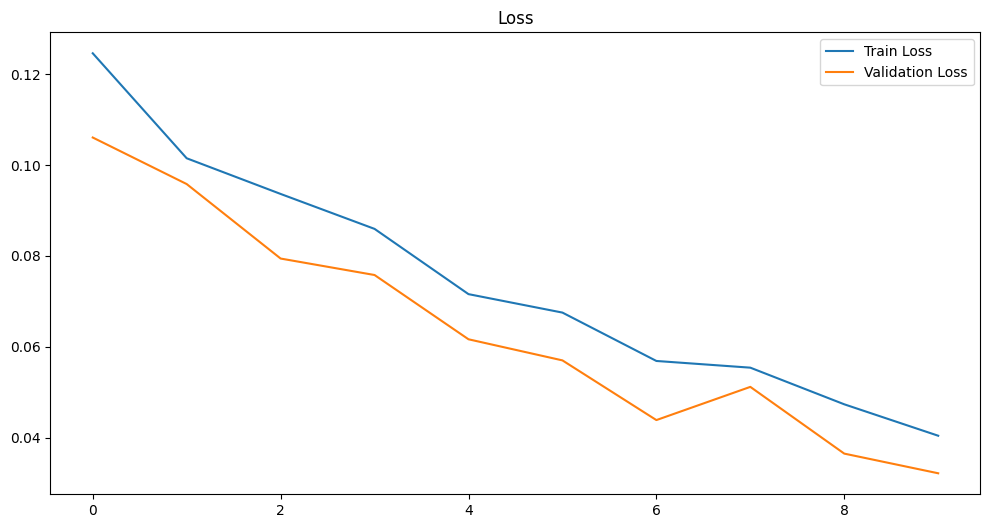

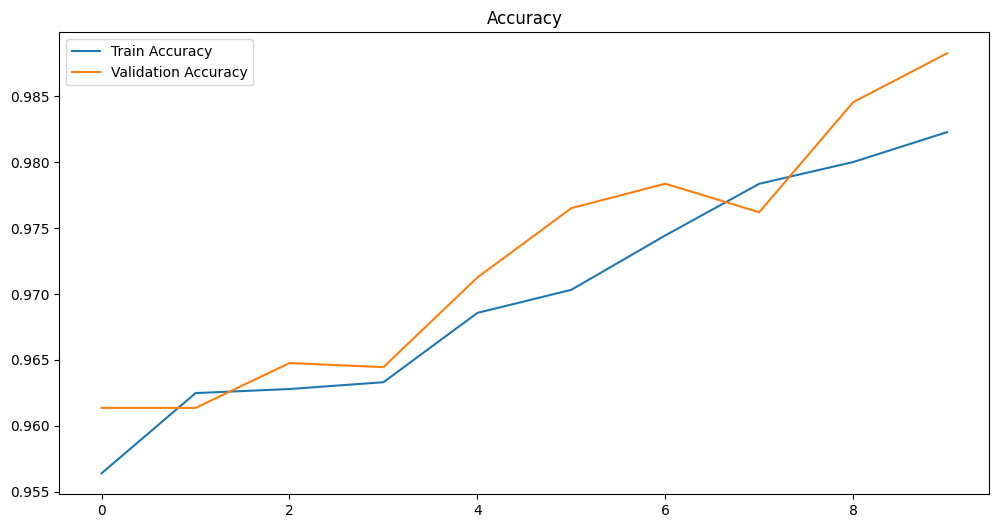

In [9]:
# Plot Training History
plt.figure(figsize=(12, 6))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history["accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

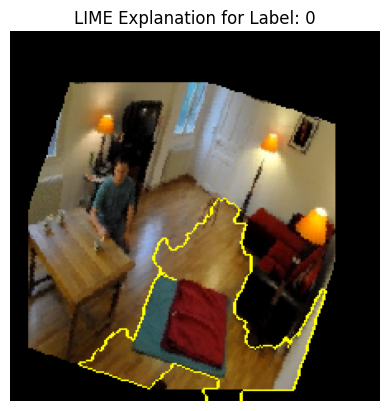

In [12]:
# LIME Explainability (Updated for MobileNetV2)
def explain_with_lime(model, dataset, idx):
    explainer = lime_image.LimeImageExplainer()
    img, label = dataset[idx]
    img_np = img.permute(1, 2, 0).numpy()

    def predict(images):
        model.eval()
        images = torch.tensor(images.transpose(0, 3, 1, 2)).float().to(device)
        outputs = model(images) # Adjusted for MobileNetV2
        # Return probabilities for both classes in a 2D array
        return torch.cat([1 - outputs, outputs], dim=1).detach().cpu().numpy()


    explanation = explainer.explain_instance(
        img_np, predict, top_labels=2, hide_color=0, num_samples=1000
    )

    # Visualize superpixels
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for Label: {label}")
    plt.axis('off')
    plt.show()

# Use LIME to explain a prediction
explain_with_lime(model, dataset, idx=0)
